# Aula - Feature Selection

Nas próximas duas aulas vamos explorar os seguintes tópicos em Python:

- 1) Introdução
- 2) Métodos de seleção de features supervisonado
- 3) Métodos de filtro
- 4) Métodos wrapper
- 5) Métodos híbridos
- 6) Médotos embutidos


In [1]:
import numpy  as np
import pandas as pd 

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split

import warnings
warnings.filterwarnings('ignore')

In [2]:
from sklearn.metrics import classification_report, ConfusionMatrixDisplay

def metricas_classificacao(estimator, X_train, X_test, y_train, y_test):
    
    # ============================================

    print("\nMétricas de avaliação de treino:")

    y_pred_train = estimator.predict(X_train)

    ConfusionMatrixDisplay.from_predictions(y_train, y_pred_train)
    plt.show()

    print(classification_report(y_train, y_pred_train))

    # ============================================

    print("\nMétricas de avaliação de teste:")

    y_pred_test = estimator.predict(X_test)

    ConfusionMatrixDisplay.from_predictions(y_test, y_pred_test)
    plt.show()

    print(classification_report(y_test, y_pred_test))

Vamos utilizar o dataset Breast Cancer

In [3]:
from sklearn import datasets
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
#
# Load do Dataset Breast Cancer
bc = datasets.load_breast_cancer(as_frame=True)
X = bc.data
y = bc.target

# Cria training and test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

In [4]:
X_train.head()

,mean radius,mean texture,mean perimeter,mean area,mean smoothness,mean compactness,mean concavity,mean concave points,mean symmetry,mean fractal dimension,...,worst radius,worst texture,worst perimeter,worst area,worst smoothness,worst compactness,worst concavity,worst concave points,worst symmetry,worst fractal dimension
469,11.62,18.18,76.38,408.8,0.11750,0.14830,0.10200,0.05564,0.1957,0.07255,...,13.36,25.40,88.14,528.1,0.17800,0.28780,0.31860,0.14160,0.2660,0.09270
561,11.20,29.37,70.67,386.0,0.07449,0.03558,0.00000,0.00000,0.1060,0.05502,...,11.92,38.30,75.19,439.6,0.09267,0.05494,0.00000,0.00000,0.1566,0.05905
443,10.57,18.32,66.82,340.9,0.08142,0.04462,0.01993,0.01111,0.2372,0.05768,...,10.94,23.31,69.35,366.3,0.09794,0.06542,0.03986,0.02222,0.2699,0.06736
362,12.76,18.84,81.87,496.6,0.09676,0.07952,0.02688,0.01781,0.1759,0.06183,...,13.75,25.99,87.82,579.7,0.12980,0.18390,0.12550,0.08312,0.2744,0.07238
271,11.29,13.04,72.23,388.0,0.09834,0.07608,0.03265,0.02755,0.1769,0.06270,...,12.32,16.18,78.27,457.5,0.13580,0.15070,0.12750,0.08750,0.2733,0.08022


In [5]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 398 entries, 469 to 176
Data columns (total 30 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   mean radius              398 non-null    float64
 1   mean texture             398 non-null    float64
 2   mean perimeter           398 non-null    float64
 3   mean area                398 non-null    float64
 4   mean smoothness          398 non-null    float64
 5   mean compactness         398 non-null    float64
 6   mean concavity           398 non-null    float64
 7   mean concave points      398 non-null    float64
 8   mean symmetry            398 non-null    float64
 9   mean fractal dimension   398 non-null    float64
 10  radius error             398 non-null    float64
 11  texture error            398 non-null    float64
 12  perimeter error          398 non-null    float64
 13  area error               398 non-null    float64
 14  smoothness error        

In [6]:
y.head()

0    0
1    0
2    0
3    0
4    0
Name: target, dtype: int64

In [7]:
y.value_counts()

1    357
0    212
Name: target, dtype: int64

____
____
_____

## 1) Introdução

O processo de **feature selection** (**seleção de atributos**) consiste na escolha, com base em alguns critérios, de um **subconjunto do conjunto original** de features de um dado problema que proporcionem um modelo com performance comparável ao modelo treinado com todas as features. 

<img src=https://miro.medium.com/max/694/0*D_jQ5yBsvCZjEYIW width=400>

O resultado do processo de feature selection é uma **redução na dimensionalidade** do espaço de features do problema (mas aqui, diferente do PCA, trabalhamos no espaço de features originais!)

Assim, o processo remove features redundantes ou irrelevantes. 

Dentre as vantagens do procedimento, podemos destacar:

- Maior eficiência no treinamento (afinal, reduzimos a quantidade de informação a ser processada);
- Eliminação de redundâncias (como multicolinearidade, por exemplo, que pode ser problemática para alguns estimadores);
- Um modelo com menos features é, em geral, mais facilmente interpretável;
- Ao reduzirmos o número de features, a complexidade da hipótese é reduzida, o que pode favorecer a generalização e melhorar a predição do estimador;


O princípio da [navalha de Occam](https://pt.wikipedia.org/wiki/Navalha_de_Ockham) é relevante no contexto de feature selection em projetos de machine learning. Sugiro [este post](https://machinelearningmastery.com/ensemble-learning-and-occams-razor/#:~:text=Occam's%20razor%20suggests%20that%20in,narrow%20and%20not%20generalize%20well.) para uma discussão deste princípio como uma heurística para a construção de modelos. Para uma discussão mais profunda, sugiro [este paper](https://www.aaai.org/Papers/KDD/1998/KDD98-006.pdf).

Alguns modelos que são sensíveis à atributos irrelevantes:
 - Regressão Linear e Logística (principalmente se forem correlacionados)
 - KNN
 - SVM
 - Redes Neurais

## Etapas do pré-processamento dos dados

<img src="images/pre-processing_order.png" width=700>

## Tipos de métodos de feature selection
Assim como temos modelos supervisionados e não supervisionados, teremos técnicas de seleção de feature que dependem da variável target ou não:

<img src='https://www.kdnuggets.com/wp-content/uploads/Fig1-Butvinik-feature-selection-overview.jpg' text='https://www.kdnuggets.com/2021/06/feature-selection-overview.html'>

## 2) Técnicas Supervisionadas
Nesta aula, estudaremos alguns métodos de seleção de features que utilizam o target.


Podemos classificar os métodos de seleção de features supervisionados de acordo com a sua interação com o modelo de aprendizado: 

<img src="https://www.kdnuggets.com/wp-content/uploads/Fig3-Butvinik-feature-selection-overview.jpg" text="https://www.kdnuggets.com/2021/06/feature-selection-overview.html"/>


### 1. Filtro

Aqui, utilizamos técnicas estatísticas como ganho de informação, teste qui-quadrado, pontuação de Fisher, coeficiente de correlação, correlação com o target e threshold de variância para determinar quais são as features mais importantes. As features são rankeadas de acordo com a técnica estatística escolhida e as melhores são selecionadas. Esse método independe do estimador escolhido e necessita de menos tempo computacional. A principal vantagem é que podemos trocar o estimador que as principais features serão as mesmas, não necessitando refazer essa etapa.

A técnica estatística a ser escolhida dependerá do tipo da sua variável dependente, se o target é categórico ou contínuo, e dos tipos da suas variáveis independentes, se suas features são categóricas ou contínuas.

<img src="https://machinelearningmastery.com/wp-content/uploads/2019/11/How-to-Choose-Feature-Selection-Methods-For-Machine-Learning.png" text='machinelearningmastery.com/feature-selection-with-real-and-categorical-data/' width=600px>

Vamos agora ver um exemplo de filtro utilizando o 
[SelectKBest](https://scikit-learn.org/stable/modules/generated/sklearn.feature_selection.SelectKBest.html#sklearn.feature_selection.SelectKBest) do sklearn

In [8]:
from sklearn.feature_selection import SelectKBest, f_classif

fs = SelectKBest(f_classif, k=10)
X_new = fs.fit_transform(X_train, y_train) # o retorno é um array

print(f'Quantidade de features antes: {X_train.shape[1]}, quantidade de features depois {X_new.shape[1]}')

Quantidade de features antes: 30, quantidade de features depois 10


In [9]:
X_new

array([[1.162e+01, 7.638e+01, 4.088e+02, ..., 5.281e+02, 3.186e-01,
        1.416e-01],
       [1.120e+01, 7.067e+01, 3.860e+02, ..., 4.396e+02, 0.000e+00,
        0.000e+00],
       [1.057e+01, 6.682e+01, 3.409e+02, ..., 3.663e+02, 3.986e-02,
        2.222e-02],
       ...,
       [1.365e+01, 8.788e+01, 5.689e+02, ..., 7.062e+02, 1.759e-01,
        8.056e-02],
       [1.705e+01, 1.134e+02, 8.950e+02, ..., 1.189e+03, 5.018e-01,
        2.543e-01],
       [9.904e+00, 6.460e+01, 3.024e+02, ..., 3.902e+02, 3.486e-01,
        9.910e-02]])

In [10]:
# get_feature_names_out retorna o nome das features selecionadas


array(['mean radius', 'mean perimeter', 'mean area', 'mean concavity',
       'mean concave points', 'worst radius', 'worst perimeter',
       'worst area', 'worst concavity', 'worst concave points'],
      dtype=object)

In [11]:
# scores_ retorna o score de cada uma das features


array([4.80594009e+02, 7.30809534e+01, 5.19551421e+02, 4.50499138e+02,
       6.82480951e+01, 2.35101305e+02, 3.65480510e+02, 6.35025749e+02,
       5.24483545e+01, 5.31343724e-03, 2.22806961e+02, 1.27184749e+00,
       2.06798349e+02, 2.78960274e+02, 5.34605383e+00, 3.51063285e+01,
       2.36099869e+01, 7.68295227e+01, 5.00864231e-02, 7.85634972e-01,
       6.17391336e+02, 9.84586408e+01, 6.43459905e+02, 4.86344354e+02,
       9.34278899e+01, 2.37748913e+02, 3.35294070e+02, 7.32283255e+02,
       9.58762662e+01, 5.19076118e+01])

In [12]:
for i in zip(X_train.columns, fs.scores_):
    print(i)

('mean radius', 480.5940091197921)
('mean texture', 73.08095339361246)
('mean perimeter', 519.5514214259588)
('mean area', 450.49913811976836)
('mean smoothness', 68.24809509035939)
('mean compactness', 235.10130508217816)
('mean concavity', 365.4805099358985)
('mean concave points', 635.0257490469319)
('mean symmetry', 52.44835447488636)
('mean fractal dimension', 0.00531343723989453)
('radius error', 222.80696125355692)
('texture error', 1.2718474925637684)
('perimeter error', 206.79834937961834)
('area error', 278.96027418566905)
('smoothness error', 5.346053826057126)
('compactness error', 35.10632849853479)
('concavity error', 23.609986868535493)
('concave points error', 76.82952268685312)
('symmetry error', 0.05008642306429728)
('fractal dimension error', 0.7856349715005921)
('worst radius', 617.3913359033312)
('worst texture', 98.45864081795534)
('worst perimeter', 643.4599048186216)
('worst area', 486.34435439438516)
('worst smoothness', 93.42788988624137)
('worst compactness',

______________

### 2. Wrapper

Nesse método, diferentes combinações de features são selecionadas, avaliadas utilizando-se um modelo e comparadas com as outras combinações com base dos resultados desse estimador. Dessa forma, a escolha das features depende do estimador escolhido e a busca será feita em todas as possíveis combinações de features utilizando a métrica escolhida.

Os métodos mais conhecidos são: <br>
* Forward selection - [SequentialFeatureSelector](https://scikit-learn.org/stable/modules/generated/sklearn.feature_selection.SequentialFeatureSelector.html) <br>
* Backward elimination - [SequentialFeatureSelector](https://scikit-learn.org/stable/modules/generated/sklearn.feature_selection.SequentialFeatureSelector.html), [RFE](https://scikit-learn.org/stable/modules/generated/sklearn.feature_selection.RFE.html#sklearn.feature_selection.RFE) <br>
* Stepwise selection (Bi-directional elimination) - [SequentialFeatureSelector do mlxtend](http://rasbt.github.io/mlxtend/api_subpackages/mlxtend.feature_selection/#sequentialfeatureselector)<br>
* Permutation Importance - [permutation_importance](https://scikit-learn.org/stable/modules/generated/sklearn.inspection.permutation_importance.html)
<br><br>

__Foward Selection__

Etapas:

1) Começa com um modelo que não contém variáveis (chamado de Null Model)
2) Faz um modelo com cada uma das features separadamente
3) Escolhe a feature mais significativa
4) Roda modelos com a feature selecionada e adicionando mais uma
5) Escolhe o melhor modelo
6) Repete processo 4 e 5 até acabarem as features

<img src="https://quantifyinghealth.com/wp-content/uploads/2019/10/forward-stepwise-algorithm.png" text="https://quantifyinghealth.com/stepwise-selection/" width=400>


<br>

__Backward Selection__

Etapas:

1) Roda um modelo com todas as features
2) Escolhe a feaute menos significativa e elimina ela
3) Roda um modelo com as features restantes
4) Repete o processo 2 e 3 sequencialmente

A vantagem do Backward Selection é considerar a interação entre as features antes de eliminá-las, mas se o número de features for muito grande a seleção pode demorar demais.

<br>

__Bi-directional Elimination__

Muito semelhante ao Foward selection, mas ao adicionar uma nova variável ele verifica a importantância de todas as features e se encontrar alguma com significância menor que a determinada previamente, remove essa feature específica por meio do Backward Elimination.

Portanto, é uma combinação de seleção para frente e eliminação para trás.

Etapas:

1) Determine um nível de significância para adicionar e remover features do modelo (por exemplo, significancia_add = 0,05 e significancia_remove = 0,05 com 95% de confiança).

2) Execute a próxima etapa do Foward Selection (a feature recém-adicionada deve ter valor p-value < significancia_add para entrar).

3) Execute todas as etapas de eliminação para trás. Ou seja, qualquer recurso adicionado anteriormente com p-value > significancia_remove será removido do modelo).

4) Repita as etapas 2 e 3 até obtermos um conjunto final ótimo de recursos.


Para saber mais acesse o [link 1](https://quantifyinghealth.com/stepwise-selection/) e [link 2](https://www.analyticsvidhya.com/blog/2020/10/a-comprehensive-guide-to-feature-selection-using-wrapper-methods-in-python/)

#### RFE

Conheceremos agora o método **Recursive Feature Elimination** (RFE).

O RFE é um método que se utiliza de um estimador capaz de atribuir um score de **importância** a cada uma das features.

> Por exemplo, podemos olhar para os coeficientes de um modelo linear (`coef_`), ou então, para os scores de importância de features (`feature_importances_`). Esse método só irá funcionar se o estimador escolhido retorna `coef_` ou `feature_importances_`.

O método então considera recursivamente **subconjuntos cada vez menores de features**, da seguinte maneira:

- O estimador é treinado inicialmente com todas as features;
- A importância de cada uma das features é calculada;
- As features menos importantes são retiradas do conjunto de features;
- O processo recomeça, até que o número  desejado de features seja alcançado.

Sendo assim, temos dois hiperparâmetros importantes na classe [sklearn.feature_selection.RFE](https://scikit-learn.org/stable/modules/generated/sklearn.feature_selection.RFE.html):

- `estimator`: o estimador que irá disponibilizar os scores de importância de features;
- `n_features_to_select`: a quantidade de features que o subconjunto final terá.

Na prática, podemos utilizar um gridsearch para otimizar estes dois hiperparâmetros, ou então utilizar a classe [RFECV](https://scikit-learn.org/stable/modules/generated/sklearn.feature_selection.RFECV.html), que determina o melhor número de features automaticamente.

Vamos ver o método na prática!

In [13]:
# Vamos usar como estimador uma DT e escolher as 10 features mais importantes
# importa classes do DT e RFE


# instancia e faz o fit com RFE


In [14]:
# support_ retorna uma máscara com as features selecionadas


array([False, False, False, False, False, False, False, False, False,
        True, False,  True, False,  True,  True, False, False, False,
       False, False,  True,  True, False, False,  True,  True,  True,
        True, False, False])

In [15]:
# ranking_ retorna a posição em que as features foram selecionadas


array([21, 20, 19, 18, 17, 16, 15, 13, 12,  1,  7,  1,  6,  1,  1,  5,  4,
        9, 14, 11,  1,  1,  3,  2,  1,  1,  1,  1,  8, 10])

Vamos ver como funciona o [RFECV](https://scikit-learn.org/stable/modules/generated/sklearn.feature_selection.RFECV.html):

In [ ]:
# Importa classes do RFECV e StratifiedKFold


# instancia StratifiedKFold


# instancia e faz o fit com RFE


Assim como na classe do cross validate, ele retorna um dicionário com os scores de cada split no método `cv_results_`.

In [20]:
# Para saber o número de features escolhidos via CV usamos o n_features_


2

In [ ]:
# Também podemos ver graficamente


Na prática, podemos incluir o RFE como um passo da Pipeline e otimizar seus parâmetros com o grid search!

In [24]:
from sklearn.pipeline import Pipeline
from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import AdaBoostClassifier

In [ ]:
# Instancia RFE e AdaBoost
rfe = RFE(estimator=DecisionTreeClassifier(random_state=42))
estimator = AdaBoostClassifier(base_estimator=DecisionTreeClassifier(max_depth=1,
                                                                     criterion="gini",
                                                                     max_features="sqrt",
                                                                     random_state=42),
                               random_state=42)

# Cria pipeline


# Define param_grid


# Instancia StratifiedKFold


# Instancia RandomizedSearchCV


# Fit do RandomizedSearchCV



Percebam que utilizamos um modelo para escolher as melhores features (DT) e outro para predizer nosso target. Não é obrigatório utilizarmos o mesmo modelo, mas a escolha de features estará otimizada para o modelo usado no método wrapper.

In [ ]:
# retorna melhores parâmetros


In [ ]:
# Printa métricas de classificação


Vamos rodar o modelo sem RFE para comparar

### Permutation importance

Neste método, utilizamos a função [`sklearn.inspection.permutation_importance()`](https://scikit-learn.org/stable/modules/generated/sklearn.inspection.permutation_importance.html), que vai criar permutações das features, mantendo um registro do score. O permutation_importance é definido como a diminuição no score de um modelo quando uma única feature é embaralhada aleatoriamente. Este procedimento quebra a relação entre a feature e o target e utiliza a queda na pontuação do modelo como um indicativo de quanto o modelo depende dessa feature.

Por realizar diversas permutações, este método é mais custoso, mas tem a vantagem de eliminar o viés que features de alta cardinalidade carregam com o método baseado em impureza.

Para maiores detalhes sobre o método, [clique aqui!](https://scikit-learn.org/stable/modules/permutation_importance.html#permutation-importance)

> Observação: este é um método que pode ser usado com qualquer estimador!

In [ ]:
from sklearn.inspection import permutation_importance

# Faz o fit do Adaboost


# Calcula o permutation_importance


In [ ]:
# Cria dicionário o importances_mean e importances_std


# Cria df a partir do dicionário


In [ ]:
plt.figure(figsize=(12, 7))
plt.title("Feature importances using permutation importance")
plt.barh(df_perm.index, df_perm["importance"], xerr=df_perm["std"])
plt.xlabel("score")
plt.show()

_______________________________________________________________________________________
<br>

### 3. Metodologia Híbrida

Nessa metodologia o intuito é definir as principais features com um método de filtro e depois aplicas o método de wrapper para reduzir o espaço de features. Dessa forma, reduzimos a quantidade de testes a serem realizados por este último.
<br><br><br>
_______________________________________________________________________________________
<br>

### 4. Metodologia Embutida/Intrínseca (Embedded/Intrinsic)

Nessa metodologia o próprio estimador possui uma forma de seleção de features. Os principais exemplos são métodos de árvore e regressão Lasso. 
No primeiro, a árvore seleciona uma feature em cada divisão, deixando por último as features menos relevantes. No segundo, as features menos relevantes têm o seu coeficiente zerado.

#### LASSO

Já conhecemos um método capaz de realizar feature selection: a **regularização L1 (LASSO)**.

Diferente da regularização L2, quando utilizamos regularização L1 é possível zerar alguns dos parâmetros do modelo:

<img src=https://ugc.futurelearn.com/uploads/assets/2b/fe/2bfe399e-503e-4eae-9138-a3d7da738713.png width=800>

Embora ambas as modalidades de regularização tenham sido introduzidas com o intuito de simplificar o espaço de hipóteses, o LASSO faz isso de maneira explícita, efetivamente possibilitando a realização de feature selection!

No entanto, há um problema: são poucos os métodos que têm o LASSO incorporado (ex.: regressão linear, logística, XGBoost).

Assim, se quisermos realizar feature selection utilizando outros estimadores, precisamos de técnicas mais genéricas, que foi o que vimos.

Para utilizarmos o L1, uma abordagem possível é:

- **treinar inicialmente um modelo com LASSO**; 
- identificar quais features **ainda estão presentes no modelo** (isto é, com `coef_` não nulo);
- utilizar apenas estas features para treinar o estimador desejado.

Vamos ver como o Lasso se comporta em um dataset conhecido?

In [33]:
# Scale das features é obrigatório já que faremos uma regressão linear
sc = MinMaxScaler()
X_train_sc = sc.fit_transform(X_train)
X_test_sc = sc.transform(X_test)

Vamos criar um loop que calculará o valor dos coeficientes e a métrica de erro conforme aumentamos o valor da regularização $\lambda$

In [34]:
from sklearn.linear_model import Lasso

alphas = []
coefs = []
test_scores = []
train_scores = []

for alpha in np.arange(0, 0.002, 0.00001):
    # Cria uma instância do Lasso Regression
    lasso = Lasso(alpha=alpha)
    
    # Fit Lasso model
    lasso.fit(X_train_sc, y_train)
    
    # Salva os scores do modelo (nesse caso é o coeficiente de determinação R²)
    train_scores.append(lasso.score(X_train_sc, y_train))
    test_scores.append(lasso.score(X_test_sc, y_test))

    # Salva o valor de alpha usado
    alphas.append(alpha)

    # Salva o valor dos coeficientes estimados
    coefs.append(lasso.coef_)

In [ ]:
# Concatena os valores de alpha e dos coeficientes em uma única lista
concat_data = [np.append(alphas[i], coefs[i]) for i in range(len(alphas))]

# Cria dataframe com um valor de lambda por linha e as colunas como valores dos coeficientes
df = pd.DataFrame(concat_data, columns=['lambda']+bc.feature_names.tolist())
df.head(10)

Aqui já podemos ver que alguns coeficientes foram zerados pela regularização. Vamos olhar o heatmap de correlação entre as features:

In [ ]:
sns.clustermap(df.drop('lambda', axis=1).corr(), method="complete", cmap='RdBu', annot=True, 
               annot_kws={"size": 7}, vmin=-1, vmax=1, figsize=(15,12));

Temos muitas variáveis independentes correlacionadas e já sabemos que isso impacta no nosso modelo de regressão linear. Lasso escolhe aleatóriamente uma das variáveis multicolineares e zera as demais. Isso pode impactar na interpretabilidade do nosso modelo.

Vamos ver como fica o coeficiente de determinação tanto para o treino quanto para o teste conforme aumentamos nossa regularização $\lambda$.

In [ ]:
plt.figure(figsize=(10,6))
sns.lineplot(x=alphas, y=train_scores, label='Train')
sns.lineplot(x=alphas, y=test_scores, label='Teste')
plt.ylabel('Coeficiente de determinação (R²)')
plt.xlabel('Lambda')
plt.title('Qual o impacto da regularização Lasso no erro de predição do treino e do teste?');

Conforme esperado, o R² do treino diminui com o aumento da regularização enquanto o do teste atinge um plato próximo de 0.75 e depois começa a cair. Nosso valor ideal de regularização está próximo de $\lambda = 0.00015$.

Vamos ver agora como o aumento da regularização afeta os coeficientes das nossa features:

In [ ]:
x_lim = [-0.00001, 0.0012]
figure_size = (15,7)
df.plot(x='lambda', figsize=figure_size)
plt.axvline(x=0.00015, linestyle='--')
plt.xlim(x_lim)
plt.legend(loc='center left', bbox_to_anchor=(1.0, 0.5))
plt.ylabel('Coeficientes encontrados')
plt.xlabel('Lambda')
plt.title('Qual o impacto da regularização Lasso nos coeficientes?', size=16);

Também podemos ver quantas features sobram conforme aumentamos a regularização:

In [ ]:
qtd_features_zeradas = df.groupby('lambda').agg(lambda x: x.ne(0).sum()).sum(axis=1).reset_index()
plt.figure(figsize=figure_size)
sns.lineplot(data=qtd_features_zeradas, x='lambda', y=0)
plt.xlim(x_lim)
plt.ylim([0, 33])
plt.ylabel('Coeficientes não zerados')
plt.xlabel('Lambda')
plt.title('Qual a quantidade de coeficientes zerados com o aumento da regularização Lasso?', size=16);

Por esse gráfico percebemos que algumas variáveis vão a zero muito rapidamente

[link](https://afit-r.github.io/regularized_regression)

______________

#### Feature importance com árvores

Além de estimadores poderosos, podemos utilizar modelos baseados em árvores para fazer feature selection! 

#### `.feature_importances_`

Neste caso, o score de importância de cada uma das features é calculado com base na **média e desvio padrão da diminuição de impureza que cada feature proporciona na árvore (ou em cada árvore, no caso de ensembles)**.

O método é conhecido como **mean decrease in impurity** (MDI).

Este método é rápido, no entanto, o valor é fortemente enviesado para features que têm alta cardinalidade (features numéricas, ou features categóricas com muitos níveis).

In [47]:
from sklearn.ensemble import RandomForestClassifier

# instancia e faz o fit do RF
rf = RandomForestClassifier(n_estimators=50,
                            random_state=42).fit(X_train, y_train)

In [ ]:
# cria series com o nome da feature e o importance
feature_importances_rf = pd.Series(rf.feature_importances_, index=rf.feature_names_in_).sort_values(ascending=False)
feature_importances_rf

In [ ]:
# plota o feature importance
plt.figure(figsize=(12, 7))
plt.title("Feature importances using MDI")
plt.barh(feature_importances_rf.index, feature_importances_rf.values)
plt.xlabel("Mean decrease in impurity");

A partir daqui, o próximo passo seria treinar um modelo normalmente (pipeline, gridsearch, etc.), mas apenas com essas features selecionadas (idealmente, uma combinação dessas heurísticas).

Nota: Sempre verifique se você obtém os mesmos resultados com um random_seed diferente antes de interpretar qualquer classificação de importância. Se os resultados mudarem, aumente o número de árvores com `ntree`.

________________________________________________________________

#### Qual método é melhor?
Como um bom cientista de dados, você terá que realizar vários experimentos para descobrir qual método é melhor para o seu caso!

Mas você pode também usar alguns métodos e selecionar todas as features que foram consideradas importantes por pelo menos 1 ou 2 deles.

________________________________________________________________
________________________________________________________________

## Bibliografia e Aprofundamento
- [Breve introdução dos métodos supervisionados e não supervisionados de seleção de features](https://www.kdnuggets.com/2021/06/feature-selection-overview.html)
- [Lista de estratégias](https://towardsdatascience.com/feature-selection-a-comprehensive-list-of-strategies-3fecdf802b79)
- [MUITOS métodos diferentes](https://medium.com/analytics-vidhya/feature-selection-extended-overview-b58f1d524c1c)
- [Wrapper methods](https://quantifyinghealth.com/stepwise-selection/)
- [Understanding Bias in RF Variable Importance Metrics](https://blog.methodsconsultants.com/posts/be-aware-of-bias-in-rf-variable-importance-metrics/)
- [Feature Importance x Permutation Importance](https://scikit-learn.org/stable/auto_examples/inspection/plot_permutation_importance.html#sphx-glr-auto-examples-inspection-plot-permutation-importance-py).

________________________________________________________________
________________________________________________________________
________________________________________________________________

### Material Complementar: Técnicas Supervisionadas

#### Como encontrar o número ideal de features?
Método 1:

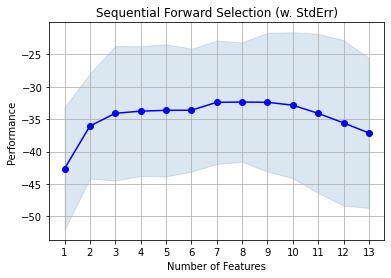

In [67]:
#Load needed libraries
from mlxtend.feature_selection import SequentialFeatureSelector as SFS
from mlxtend.plotting import plot_sequential_feature_selection as plot_sfs
from sklearn.linear_model import LinearRegression
from sklearn.datasets import load_boston
import matplotlib.pyplot as plt

#import and prepare data
boston = load_boston()
X, y = boston.data, boston.target

#Define Sequential Forward Selection (sfs)
sfs = SFS(LinearRegression(), 
          k_features=13, 
          forward=True, 
          floating=False, 
          scoring='neg_mean_squared_error',
          cv=5)

sfs = sfs.fit(X, y)
fig = plot_sfs(sfs.get_metric_dict(), kind='std_err')

plt.title('Sequential Forward Selection (w. StdErr)')
plt.grid()
plt.show()

#https://towardsdatascience.com/feature-selection-for-machine-learning-in-python-wrapper-methods-2b5e27d2db31

Método 2:

Adicione uma variável randômica no seu dataset e faça o feature importance. Qualquer feature que tenha uma importância menor que a da feature randômica pode ser desconsiderada.

In [ ]:
np.random.seed(33) #o permutation deu pior com seed 33 ou 37 e random.randint indo de -10000, 10000
X_train['random_1'] = np.random.randint(-100, 100, size=X_train.shape[0])/100

rf = RandomForestClassifier(n_estimators=50,
                            random_state=42).fit(X_train, y_train)

feature_importances_rf = pd.Series(rf.feature_importances_, index=rf.feature_names_in_).sort_values(ascending=False)

plt.figure(figsize=(12, 7))
plt.title("Feature importances using MDI")
plt.barh(feature_importances_rf.index, feature_importances_rf.values)
plt.xlabel("Mean decrease in impurity");

________________________________________________________________

### Material Complementar: Técnicas Não Supervisionadas

<img src="https://www.kdnuggets.com/wp-content/uploads/Fig4-Butvinik-feature-selection-overview.jpg" text="https://www.kdnuggets.com/2021/06/feature-selection-overview.html" width=900/>

Aqui também podemos separar nossos métodos de acordo com a interação com o modelo:

### 1. Filtro

Os métodos de filtro podem ser classificados como univariados e multivariados. Da mesma forma que nas técnicas supervisionadas, aqui ordenamos as features de acordo com o método estatístico selecionado. No caso dos univariados, cada feature é analisada separadamente e por isso não é capaz de eliminar features correlacionadas. No multivariado, as features são avaliadas em conjunto em vez de individualmente. 

### 2. Wrapper

O métodos wrapper podem ser divididos em três categorias: sequencial, bio-inspirado e iterativo. 

Na metodologia sequencial, os recursos são adicionados ou removidos sequencialmente. Na bioinspirada, tenta-se incorporar a aleatoriedade no processo de busca, com o intuito de escapar de ótimos locais. Nos iterativos fazemos uma estimação evitando, assim, uma busca combinatória.

Assim como nos métodos wrapper supervisionados, esta abordagem caracteriza-se por encontrar subconjuntos de features que sejam mais relevantes. Porém, ela possui um alto custo computacional.

### 3. Metodologia Híbrida

Da mesma forma que nos supervisionados, a primeira etapa dessa metodologia consiste em filtrar os recursos mais relevantes para depois aplicar alguma técnica de wrapper.
